# 2. Data exploration & Baseline model generation


In the previous notebook, the NY taxi trip data from Jan, Apr, July 2015 was loaded to a Postgis database called 'carto'.

In this notebook, some of the data will be used to create a GeoDataFrame.

In [522]:
# import libraries
import numpy as np
import psycopg2
import pandas as pd
import geopandas as gpd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.despine()
sns.set_context(rc={'axes.labelsize':18,
                    'axes.titlesize':18,
                    'font.size':15,
                    'legend.fontsize':15,
                    'lines.linewidth':2.2,
                    'palette':'Set1'})
import contextily as ctx

<Figure size 432x288 with 0 Axes>

In [2]:
# Function to retrieve data from postgis as gdf (geo data frame) using queries
def get_gdf(query, geom):
    # Connect to the database
    con =  psycopg2.connect(dbname='carto', user='carto', password='carto',
                            host='postgis', port='5432')

    # Save the query result as a geodataframe
    gdf = gpd.read_postgis(query, con, geom_col=geom)
    
    # Close connection
    con.close()
    return gdf

# Task 1: Merge the taxi and ACS dataset by block group and compute the average number of pickups by block group


### Prepare data

Let's take pickup related features (pickup time, pickup point) from Jan 2015 taxi data as a sample to process.

A query will select pickup points from 'taxi_jan' table **only if the points is within any census blocks**. The result will be limited to 50,000 rows due to limited memory space.

In [3]:
# Query to select 50,000 pickup data from January
# Get a geometric Point attribute using longitude & latitude
q_jan = '''
        with
        
            jan as
            (
                select
                    tpep_pickup_datetime as pickup_time,
                    ST_SetSRID(ST_MakePoint(pickup_longitude, pickup_latitude), 4326)
                    as pickup_point
                from taxi_jan
            )
        
        select jan.*
        from jan, census_blocks as census
        where ST_Contains(census.geometry, jan.pickup_point)
        LIMIT 50000;
        '''

# Save the query result as a geodataframe
pickup_jan = get_gdf(q_jan, 'pickup_point')
pickup_jan.head()

,pickup_time,pickup_point
0,2015-01-05 08:13:39,POINT (-73.97956 40.74545)
1,2015-01-03 22:28:10,POINT (-73.96609 40.76794)
2,2015-01-03 22:28:10,POINT (-73.99605 40.72090)
3,2015-01-03 22:28:10,POINT (-73.99152 40.72957)
4,2015-01-03 22:28:10,POINT (-73.95834 40.76893)


In [4]:
# General information
pickup_jan.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pickup_time   50000 non-null  datetime64[ns]
 1   pickup_point  50000 non-null  geometry      
dtypes: datetime64[ns](1), geometry(1)
memory usage: 781.4 KB


There are 50,000 records in this table without empty rows.

The datatype for each column is well assigned.

In [5]:
# Remove duplicated rows
pickup_jan = pickup_jan[~pickup_jan.duplicated()]
pickup_jan.shape

(49984, 2)

There were >10 duplicated rows removed from the original dataframe.

As this is a sample data to be used for further exploration, it'd be nice to have data from different dates of the month (in other words, to retrieve general data of the entire month without being limited to specific dates).

Data from 31 days


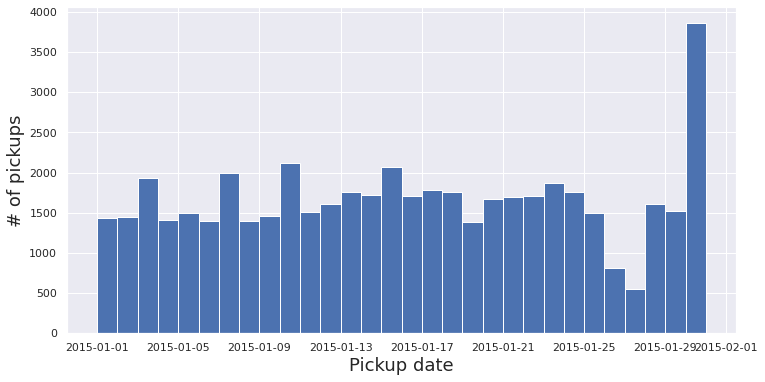

In [6]:
# Is the data from different dates of the month?
# Check the distribution of 'pickup_time' by assessing its datetime.date object.
dates_from_pickup_jan = pickup_jan.pickup_time.dt.date

print(f'Data from {len(dates_from_pickup_jan.unique())} days')

dates_from_pickup_jan.hist(bins=30, figsize=(12,6))
plt.ylabel('# of pickups')
plt.xlabel('Pickup date')
plt.show()

Note:
    
    The sample data we have was collected from day 1 to 31 of January, and despite daily variance, the amount of each day's pickup record is generally around 1,500.

### Load more data:

1 - New york's demographic & socio-economic (by census block group) dataset in .csv file
<br>
2 - Census block group geometries

Then check if there's any missing or duplicated rows from each data.

In [65]:
# Read the demographic and socio-economic data (by block group)
# from the American Community Survey (ACS) dataset
demographic = pd.read_csv('../data/nyc_acs_demographics.csv', index_col=0)
print(demographic.shape)
demographic.head()

(199630, 3)


,geoid,acs_demog_var,value
0,360050001001,total_pop,7080.0
1,360050001001,two_or_more_races_pop,41.0
2,360050001001,vacant_housing_units_for_rent,0.0
3,360050001001,unemployed_pop,0.0
4,360050001001,black_pop,3984.0


In [8]:
# Missing or duplicated values?
print(f'How many rows with missing values?: {demographic.isnull().any().sum()}')
print(f'How many duplicated rows?: {demographic.duplicated().sum()}')

How many rows with missing values?: 0
How many duplicated rows?: 0


In [9]:
# Are all data types are correctly assigned?
demographic.dtypes

geoid              int64
acs_demog_var     object
value            float64
dtype: object

In [10]:
# NYC census block group geometries
census = gpd.read_file('../data/nyc_cbg_geoms.geojson')
census.head()

,geoid,geometry
0,360050001001,"POLYGON ((-73.89277 40.79284, -73.89261 40.792..."
1,360050002001,"POLYGON ((-73.86285 40.81267, -73.86191 40.812..."
2,360050002002,"POLYGON ((-73.86708 40.81444, -73.86332 40.812..."
3,360050002003,"POLYGON ((-73.85856 40.80665, -73.85848 40.806..."
4,360050004001,"POLYGON ((-73.85972 40.81527, -73.85956 40.815..."


In [11]:
# Missing or duplicated values?
print(f'How many rows with missing values?: {census.isnull().any().sum()}')
print(f'How many duplicated rows?: {census.duplicated().sum()}')
print(f'How many blocks are there?: {len(census.geoid.unique())}')

How many rows with missing values?: 0
How many duplicated rows?: 0
How many blocks are there?: 6339


In [12]:
# Are all data types are correctly assigned?
census.dtypes

geoid         object
geometry    geometry
dtype: object

In [13]:
# Change the data type of 'geoid' column
# object -> numeric
census.geoid = pd.to_numeric(census.geoid)
census.geoid.dtype

dtype('int64')

# Visualize the data

As a first step of data exploration, let's visualize the data by projecting two dataframes with location info ('pickup_jan' & 'census') on a map.

In [14]:
# Print the current CRS (Coordinate Reference System)
print(pickup_jan.crs)
print(census.crs)

epsg:4326
epsg:4326


In [15]:
# Reproject data in Web mercator for a plot
pickup_jan = pickup_jan.to_crs(epsg=3857)
census = census.to_crs(epsg=3857)

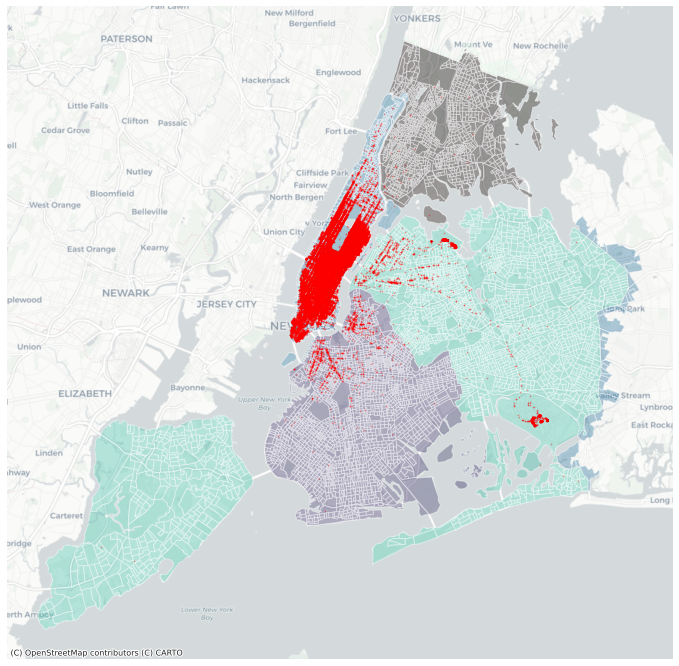

In [16]:
# Plot the census blocks (polygons)
ax = census.plot(column = 'geoid', figsize=(12, 12),
                 scheme='EqualInterval', alpha=.4, cmap='mako')

# Plot pickup points within blocks (red points)
pickup_jan.plot(ax=ax, color='red', alpha=.3, markersize=.6)

# Basemap of NY city
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_axis_off()
plt.show()

The pickup points (red points) are heavily concentrated in Manhattan area.

Let's peak at the demographic & socioeconomic status of the Manhattan and compare it with other borough's. To do that, the following steps will be taken:

1. Merge the NY census block geometry and pickup points by spatial join method
2. Merge the ACS demographic & socioeconomic dataset to data created in 1.

### 1. Join census block location data with taxi pickup data

In [ ]:
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 

In [538]:
# Spatial join
print(census.shape)
print(pickup_jan.shape)

# Left join to keep all census block ids
blocks_with_pickups = gpd.sjoin(census, pickup_jan, how='inner', op='contains')
print(blocks_with_pickups.shape)
blocks_with_pickups.head()

(6339, 2)
(49984, 2)
(49984, 4)


,index_left,geoid,pickup_time,pickup_point
0,3463,360610072005,2015-01-05 08:13:39,POINT (-8235367.043 4974867.652)
1,3633,360610120004,2015-01-03 22:28:10,POINT (-8233868.028 4978172.965)
2,3351,360610041006,2015-01-03 22:28:10,POINT (-8237202.381 4971260.890)
3,3397,360610057002,2015-01-03 22:28:10,POINT (-8236698.746 4972534.537)
4,3654,360610126001,2015-01-03 22:28:10,POINT (-8233004.290 4978318.748)


In [63]:
# Let's rename 'index_right' column
blocks_with_pickups = blocks_with_pickups.rename(columns={'index_right':'index_pickup'})

### Join ACS data

In [66]:
# Get demographic & socioeconomic dataset
# Pivot the original table for convinience
demographic = demographic.pivot_table(values='value',
                                      index='geoid',
                                      columns='acs_demog_var')
# Reset index
demographic.reset_index(inplace=True)

print(demographic.shape)
demographic.head()

(6339, 34)


acs_demog_var,geoid,aggregate_travel_time_to_work,amerindian_pop,asian_pop,black_pop,commuters_16_over,commuters_by_public_transportation,employed_pop,families_with_young_children,family_households,...,other_race_pop,owner_occupied_housing_units_median_value,pop_16_over,renter_occupied_housing_units_paying_cash_median_gross_rent,total_pop,two_or_more_races_pop,unemployed_pop,vacant_housing_units,vacant_housing_units_for_rent,white_pop
0,360050001001,NaN,25.0,125.0,3984.0,0.0,0.0,0.0,0.0,0.0,...,38.0,NaN,7080.0,NaN,7080.0,41.0,0.0,0.0,0.0,538.0
1,360050002001,NaN,0.0,0.0,468.0,608.0,271.0,608.0,63.0,356.0,...,0.0,384200.0,1543.0,1793.0,1919.0,0.0,168.0,30.0,0.0,13.0
2,360050002002,NaN,0.0,0.0,238.0,579.0,161.0,588.0,96.0,363.0,...,86.0,415300.0,1423.0,1358.0,1703.0,0.0,118.0,71.0,15.0,52.0
3,360050002003,NaN,0.0,104.0,202.0,382.0,108.0,382.0,33.0,239.0,...,0.0,374700.0,718.0,1677.0,920.0,0.0,9.0,57.0,0.0,12.0
4,360050004001,NaN,0.0,24.0,24.0,213.0,69.0,259.0,0.0,136.0,...,0.0,363900.0,417.0,1375.0,468.0,0.0,0.0,15.0,15.0,0.0


In [150]:
# Merge the demographic data with 'blocks_with_pickups' table
pickups_merged = blocks_with_pickups.merge(demographic, how='left', on='geoid')

print(pickups_merged.shape)
pickups_merged.head()

(54818, 37)


,geoid,geometry,index_pickup,pickup_time,aggregate_travel_time_to_work,amerindian_pop,asian_pop,black_pop,commuters_16_over,commuters_by_public_transportation,...,other_race_pop,owner_occupied_housing_units_median_value,pop_16_over,renter_occupied_housing_units_paying_cash_median_gross_rent,total_pop,two_or_more_races_pop,unemployed_pop,vacant_housing_units,vacant_housing_units_for_rent,white_pop
0,360050001001,"POLYGON ((-8225705.084 4981832.875, -8225687.3...",24651.0,2015-01-31 18:35:37,NaN,25.0,125.0,3984.0,0.0,0.0,...,38.0,NaN,7080.0,NaN,7080.0,41.0,0.0,0.0,0.0,538.0
1,360050002001,"POLYGON ((-8222374.517 4984750.116, -8222270.7...",NaN,NaT,NaN,0.0,0.0,468.0,608.0,271.0,...,0.0,384200.0,1543.0,1793.0,1919.0,0.0,168.0,30.0,0.0,13.0
2,360050002002,"POLYGON ((-8222845.732 4985010.161, -8222427.6...",NaN,NaT,NaN,0.0,0.0,238.0,579.0,161.0,...,86.0,415300.0,1423.0,1358.0,1703.0,0.0,118.0,71.0,15.0,52.0
3,360050002003,"POLYGON ((-8221896.845 4983863.689, -8221888.7...",NaN,NaT,NaN,0.0,104.0,202.0,382.0,108.0,...,0.0,374700.0,718.0,1677.0,920.0,0.0,9.0,57.0,0.0,12.0
4,360050004001,"POLYGON ((-8222026.087 4985131.949, -8222008.0...",NaN,NaT,NaN,0.0,24.0,24.0,213.0,69.0,...,0.0,363900.0,417.0,1375.0,468.0,0.0,0.0,15.0,15.0,0.0


In [153]:
# Count how many pickups were made within each block
n_pickup_block = pickups_merged.groupby('geoid')['index_pickup'].size()

# As dataframe
n_pickup_block = pd.DataFrame(n_pickup_block).reset_index()
n_pickup_block.columns = ['geoid', 'n_pickup']

n_pickup_block.head()

,geoid,n_pickup
0,360050001001,1
1,360050002001,1
2,360050002002,1
3,360050002003,1
4,360050004001,1


In [ ]:
!!!!!!!!!!!!!!!!!!!!! Top 10 instead of head

In [154]:
# Join it to the NY_merged dataframe
pickups_merged = pd.merge(pickups_merged,
                          n_pickup_block,
                          on='geoid',
                          copy=False)
print(pickups_merged.shape)
pickups_merged.head()

(54818, 38)


,geoid,geometry,index_pickup,pickup_time,aggregate_travel_time_to_work,amerindian_pop,asian_pop,black_pop,commuters_16_over,commuters_by_public_transportation,...,owner_occupied_housing_units_median_value,pop_16_over,renter_occupied_housing_units_paying_cash_median_gross_rent,total_pop,two_or_more_races_pop,unemployed_pop,vacant_housing_units,vacant_housing_units_for_rent,white_pop,n_pickup
0,360050001001,"POLYGON ((-8225705.084 4981832.875, -8225687.3...",24651.0,2015-01-31 18:35:37,NaN,25.0,125.0,3984.0,0.0,0.0,...,NaN,7080.0,NaN,7080.0,41.0,0.0,0.0,0.0,538.0,1
1,360050002001,"POLYGON ((-8222374.517 4984750.116, -8222270.7...",NaN,NaT,NaN,0.0,0.0,468.0,608.0,271.0,...,384200.0,1543.0,1793.0,1919.0,0.0,168.0,30.0,0.0,13.0,1
2,360050002002,"POLYGON ((-8222845.732 4985010.161, -8222427.6...",NaN,NaT,NaN,0.0,0.0,238.0,579.0,161.0,...,415300.0,1423.0,1358.0,1703.0,0.0,118.0,71.0,15.0,52.0,1
3,360050002003,"POLYGON ((-8221896.845 4983863.689, -8221888.7...",NaN,NaT,NaN,0.0,104.0,202.0,382.0,108.0,...,374700.0,718.0,1677.0,920.0,0.0,9.0,57.0,0.0,12.0,1
4,360050004001,"POLYGON ((-8222026.087 4985131.949, -8222008.0...",NaN,NaT,NaN,0.0,24.0,24.0,213.0,69.0,...,363900.0,417.0,1375.0,468.0,0.0,0.0,15.0,15.0,0.0,1


<AxesSubplot:>

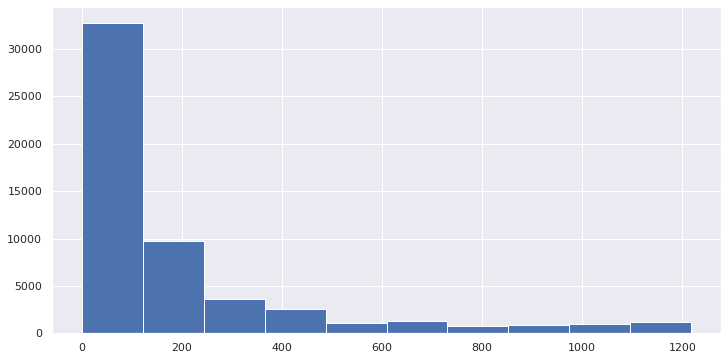

In [186]:
pickups_merged['n_pickup'].hist(figsize=(12,6))

In [188]:
# Where is the top10 pickup points?
top10_pickup_blocks = n_pickup_block.sort_values('n_pickup')[-10:][['geoid', 'n_pickup']]
top10_pickup_blocks

,geoid,n_pickup
3398,360610058001,464
3576,360610102001,474
3557,360610094001,516
3609,360610113001,529
3572,360610099001,619
3745,360610143001,630
3549,360610092001,755
5432,360810716001,907
4872,360810331001,1007
3575,360610101001,1217


In [263]:
pickups_merged[(pickups_merged.geoid == 360610058001) & ~pickups_merged.index_pickup.isnull()].shape

(464, 38)

In [189]:
# Get summary statistics of this top10 pickup points
pickups_merged.loc[top10_pickup_blocks.index].describe()

,geoid,index_pickup,aggregate_travel_time_to_work,amerindian_pop,asian_pop,black_pop,commuters_16_over,commuters_by_public_transportation,employed_pop,families_with_young_children,...,owner_occupied_housing_units_median_value,pop_16_over,renter_occupied_housing_units_paying_cash_median_gross_rent,total_pop,two_or_more_races_pop,unemployed_pop,vacant_housing_units,vacant_housing_units_for_rent,white_pop,n_pickup
count,1.000000e+01,2.000000,0.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,8.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000
mean,3.604988e+11,35693.000000,NaN,13.200000,196.000000,1021.300000,625.600000,356.600000,650.800000,91.200000,...,489000.000000,1227.500000,1354.200000,1471.700000,13.300000,61.800000,54.100000,7.80000,74.900000,8.900000
std,5.863134e+07,18957.532804,NaN,41.742065,510.548289,512.054912,179.582974,90.369857,191.053105,105.847689,...,116382.853425,551.197333,408.158412,594.795773,16.391393,39.647895,43.421577,13.15548,114.682605,24.981994
min,3.604708e+11,22288.000000,NaN,0.000000,0.000000,0.000000,264.000000,168.000000,264.000000,0.000000,...,301700.000000,485.000000,487.000000,516.000000,0.000000,0.000000,8.000000,0.00000,6.000000,1.000000
25%,3.604709e+11,28990.500000,NaN,0.000000,0.000000,855.250000,553.500000,326.500000,567.750000,22.750000,...,433000.000000,1036.750000,1250.500000,1187.000000,0.000000,33.250000,29.500000,0.00000,12.500000,1.000000
50%,3.604710e+11,35693.000000,NaN,0.000000,11.000000,1073.000000,640.000000,350.000000,675.500000,64.500000,...,521600.000000,1080.000000,1435.500000,1408.000000,8.500000,59.000000,33.000000,0.00000,28.000000,1.000000
75%,3.604711e+11,42395.500000,NaN,0.000000,56.500000,1299.500000,753.500000,400.000000,779.250000,85.750000,...,555300.000000,1362.000000,1577.000000,1664.250000,18.000000,81.500000,71.250000,12.50000,55.500000,1.000000
max,3.606100e+11,49098.000000,NaN,132.000000,1638.000000,1649.000000,870.000000,487.000000,903.000000,348.000000,...,622500.000000,2553.000000,1927.000000,2845.000000,45.000000,124.000000,136.000000,41.00000,374.000000,80.000000


In [190]:
# What about the others?
others = [i for i in pickups_merged.index if i not in top10_pickup_blocks.index]
pickups_merged.loc[others].describe()

,geoid,index_pickup,aggregate_travel_time_to_work,amerindian_pop,asian_pop,black_pop,commuters_16_over,commuters_by_public_transportation,employed_pop,families_with_young_children,...,owner_occupied_housing_units_median_value,pop_16_over,renter_occupied_housing_units_paying_cash_median_gross_rent,total_pop,two_or_more_races_pop,unemployed_pop,vacant_housing_units,vacant_housing_units_for_rent,white_pop,n_pickup
count,5.480800e+04,49982.000000,8489.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,...,3.940500e+04,54808.000000,49678.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,3.606080e+11,24997.973030,45045.057722,1.594785,223.920687,87.676927,789.683130,436.045158,863.998814,73.997592,...,1.167879e+06,1241.976810,2343.071299,1396.982977,34.237739,39.919282,159.729127,33.835517,865.378357,193.655251
std,1.041139e+08,14433.228653,34474.615992,10.624359,276.229427,202.967638,721.954397,425.065277,762.828769,103.438689,...,5.651365e+05,956.862942,765.200667,1072.427816,49.102441,48.816063,157.177531,51.591682,740.927111,268.200819
min,3.600500e+11,0.000000,6450.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.999000e+03,0.000000,229.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3.606101e+11,12499.250000,22370.000000,0.000000,43.000000,0.000000,418.000000,189.000000,464.000000,6.000000,...,7.336000e+05,746.000000,1813.000000,841.000000,0.000000,3.000000,41.000000,0.000000,439.000000,34.000000
50%,3.606101e+11,24997.500000,29635.000000,0.000000,131.000000,18.000000,667.000000,380.000000,741.000000,39.000000,...,1.042700e+06,1142.000000,2417.000000,1273.000000,14.000000,27.000000,124.000000,5.000000,743.000000,88.000000
75%,3.606101e+11,37497.750000,61980.000000,0.000000,300.000000,85.000000,975.000000,550.000000,1055.000000,106.000000,...,1.684800e+06,1512.000000,2937.000000,1672.000000,50.000000,55.000000,249.000000,55.000000,1122.000000,223.000000
max,3.611901e+11,49999.000000,195980.000000,274.000000,3960.000000,4744.000000,6483.000000,4849.000000,6767.000000,1030.000000,...,2.000001e+06,7881.000000,3501.000000,8830.000000,766.000000,575.000000,1513.000000,467.000000,6111.000000,1217.000000


# Note:


To BE ADDED LATER




# Add more features

In [ ]:
!!!!!!!!!!!!!!! ## Adding borough names

In [191]:
# Let's add address (borough names) to the data
# New York City Borough Boundaries data was downloadad:
# https://geo.nyu.edu/catalog/nyu-2451-34510

NY_borough = gpd.read_file('../data/nyu_2451_34510.shp')

# Use borough name and geometry only
NY_borough = NY_borough[['name', 'geoid', 'geometry']]

# Change crs (originally epsg:2263)
NY_borough = NY_borough.to_crs(epsg=3857)
print(NY_borough.crs)

NY_borough.head()

epsg:3857


,name,geoid,geometry
0,Bronx,36005,"POLYGON ((-8230256.493 4995020.411, -8230042.4..."
1,Kings,36047,"POLYGON ((-8243722.812 4961352.763, -8243714.4..."
2,New York,36061,"MULTIPOLYGON (((-8241476.607 4966257.884, -824..."
3,Queens,36081,"POLYGON ((-8237318.045 4947258.694, -8233157.8..."
4,Richmond,36085,"POLYGON ((-8265391.373 4945447.727, -8265384.3..."


In [286]:
# If a census block is within a NY borough, merge data
NY_merged = gpd.sjoin(pickups_merged, NY_borough, how='left', op='within')
print(NY_merged.shape)

NY_merged.head()

(54818, 41)


,geoid_left,geometry,index_pickup,pickup_time,aggregate_travel_time_to_work,amerindian_pop,asian_pop,black_pop,commuters_16_over,commuters_by_public_transportation,...,total_pop,two_or_more_races_pop,unemployed_pop,vacant_housing_units,vacant_housing_units_for_rent,white_pop,n_pickup,index_right,name,geoid_right
0,360050001001,"POLYGON ((-8225705.084 4981832.875, -8225687.3...",24651.0,2015-01-31 18:35:37,NaN,25.0,125.0,3984.0,0.0,0.0,...,7080.0,41.0,0.0,0.0,0.0,538.0,1,NaN,NaN,NaN
1,360050002001,"POLYGON ((-8222374.517 4984750.116, -8222270.7...",NaN,NaT,NaN,0.0,0.0,468.0,608.0,271.0,...,1919.0,0.0,168.0,30.0,0.0,13.0,1,0.0,Bronx,36005
2,360050002002,"POLYGON ((-8222845.732 4985010.161, -8222427.6...",NaN,NaT,NaN,0.0,0.0,238.0,579.0,161.0,...,1703.0,0.0,118.0,71.0,15.0,52.0,1,0.0,Bronx,36005
3,360050002003,"POLYGON ((-8221896.845 4983863.689, -8221888.7...",NaN,NaT,NaN,0.0,104.0,202.0,382.0,108.0,...,920.0,0.0,9.0,57.0,0.0,12.0,1,0.0,Bronx,36005
4,360050004001,"POLYGON ((-8222026.087 4985131.949, -8222008.0...",NaN,NaT,NaN,0.0,24.0,24.0,213.0,69.0,...,468.0,0.0,0.0,15.0,15.0,0.0,1,0.0,Bronx,36005


In [287]:
# Three more columns are added to the 'pickups_merged' df
# : 'index_right (=index from NY_borough table)', 'name', 'geoid_right'
# Let's keep only 'name' column
cols_to_remove = ['index_right', 'geoid_right']
NY_merged = NY_merged[[col for col in NY_merged.columns if col not in cols_to_remove]]

# Also, rename the 'name' column as 'borough'
NY_merged = NY_merged.rename(columns = {'name':'borough',
                                        'geoid_left':'geoid'})
print(NY_merged.shape)

(54818, 39)


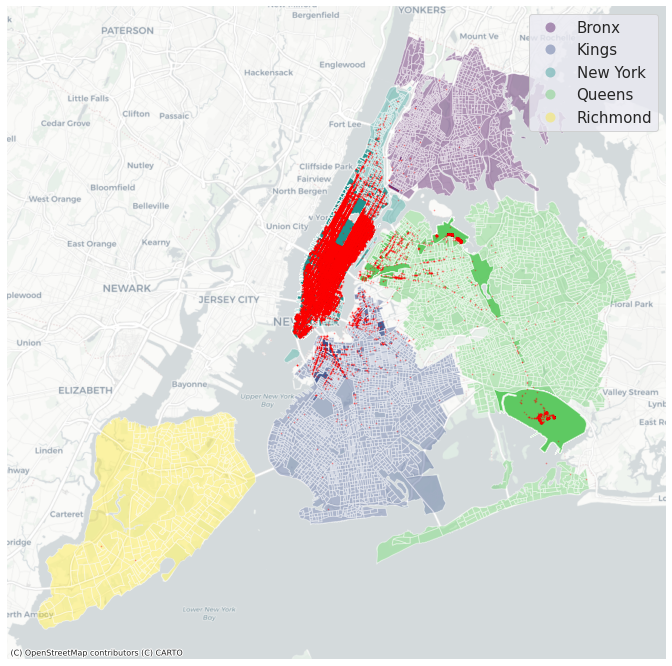

In [540]:
# Plot the census blocks (polygons)
ax = NY_merged.plot(column='borough', figsize=(12, 12),
                    alpha=.4, cmap='viridis', legend=True)

# Plot pickup points within blocks (red points)
pickup_jan.plot(ax=ax, color='red', alpha=.3, markersize=.6)

# Basemap of NY city
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_axis_off()
plt.show()

In [289]:
# Area of each borough?
borough_area = NY_borough.set_index('name').area
borough_area

name
Bronx       2.604247e+08
Kings       4.363165e+08
New York    1.518545e+08
Queens      8.028832e+08
Richmond    4.595256e+08
dtype: float64

In [290]:
# Tota population of each borough?
borough_total_pop = NY_merged.groupby('borough')['total_pop'] \
                             .sum() \
                             .sort_values(ascending=False)
borough_total_pop

borough
New York    68065847.0
Kings        3217474.0
Queens       2777543.0
Bronx        1401129.0
Richmond      474101.0
Name: total_pop, dtype: float64

In [291]:
# Population density?
pop_per_area = borough_total_pop / borough_area
pop_per_area.sort_values(ascending=False)

New York    0.448231
Kings       0.007374
Bronx       0.005380
Queens      0.003459
Richmond    0.001032
dtype: float64

New york county (= Manhattan) has the highest # of population per area. 

Is number of pickups within each county related to the size (in size and population) of the borough?

In [486]:
# Let's use a subset of data which contains pickup records
cols_to_use = ['geoid', 'n_pickup', 'borough']
NY_pickup_data = NY_merged[~NY_merged.index_pickup.isnull()][cols_to_use]

# Get unique rows only
NY_pickup_data = NY_pickup_data[~NY_pickup_data.geoid.duplicated()]

print(NY_pickup_data.shape)
NY_pickup_data.tail()

(1505, 3)


,geoid,n_pickup,borough
54325,360811227022,1,Queens
54334,360811247003,1,Queens
54434,360811483004,1,Queens
54627,360850146044,1,Richmond
54673,360850170102,1,Richmond


In [487]:
# Total n_pickups of each borough?
NY_pickup_data.groupby('borough')['n_pickup'].count().sort_values(ascending=False)

borough
New York    930
Kings       311
Queens      213
Bronx        21
Richmond      2
Name: n_pickup, dtype: int64

Note: It looks like the area with higher population gets higher pickups of taxi.

In [ ]:
# Let's get average pickups per area of each block

In [320]:
# Calculate area of each block group
print(NY_merged.shape)
area = NY_merged.set_index('geoid').area

# Remove duplicated rows
area = area[~area.duplicated()]

# Set geoid as col, not idx
area = pd.DataFrame(area, columns=['area']).reset_index()

# Join area to the pickup_blocks
NY_merged = NY_merged.merge(area, how='left', on='geoid', copy=False)
print(NY_merged.shape)

(54818, 39)
(54818, 40)


In [322]:
NY_merged['n_pickup_per_area'] = NY_merged['n_pickup'] / NY_merged['area']
NY_merged.head()

,geoid,geometry,index_pickup,pickup_time,aggregate_travel_time_to_work,amerindian_pop,asian_pop,black_pop,commuters_16_over,commuters_by_public_transportation,...,total_pop,two_or_more_races_pop,unemployed_pop,vacant_housing_units,vacant_housing_units_for_rent,white_pop,n_pickup,borough,area,n_pickup_per_area
0,360050001001,"POLYGON ((-8225705.084 4981832.875, -8225687.3...",24651.0,2015-01-31 18:35:37,NaN,25.0,125.0,3984.0,0.0,0.0,...,7080.0,41.0,0.0,0.0,0.0,538.0,1,NaN,2.928984e+06,3.414153e-07
1,360050002001,"POLYGON ((-8222374.517 4984750.116, -8222270.7...",NaN,NaT,NaN,0.0,0.0,468.0,608.0,271.0,...,1919.0,0.0,168.0,30.0,0.0,13.0,1,Bronx,1.555543e+05,6.428623e-06
2,360050002002,"POLYGON ((-8222845.732 4985010.161, -8222427.6...",NaN,NaT,NaN,0.0,0.0,238.0,579.0,161.0,...,1703.0,0.0,118.0,71.0,15.0,52.0,1,Bronx,3.881060e+05,2.576615e-06
3,360050002003,"POLYGON ((-8221896.845 4983863.689, -8221888.7...",NaN,NaT,NaN,0.0,104.0,202.0,382.0,108.0,...,920.0,0.0,9.0,57.0,0.0,12.0,1,Bronx,2.941445e+05,3.399689e-06
4,360050004001,"POLYGON ((-8222026.087 4985131.949, -8222008.0...",NaN,NaT,NaN,0.0,24.0,24.0,213.0,69.0,...,468.0,0.0,0.0,15.0,15.0,0.0,1,Bronx,1.098734e+05,9.101386e-06


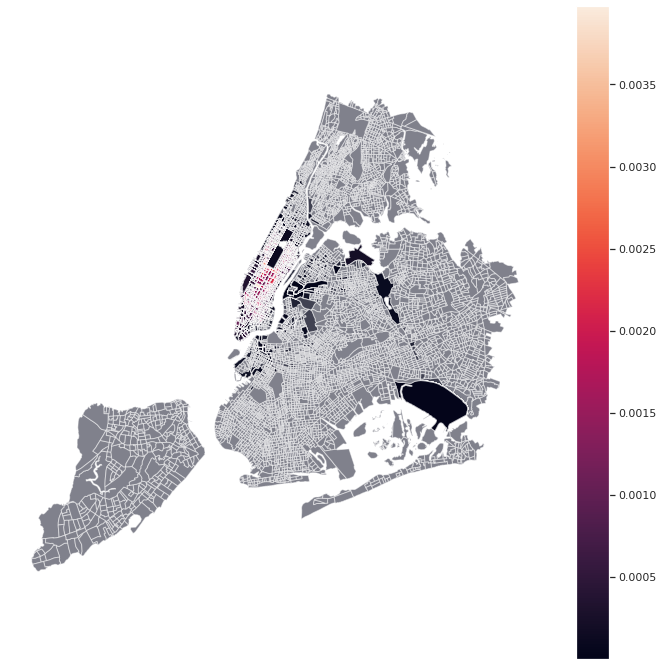

In [330]:
# Visualize the n_pickups per area
ax = NY_merged.plot(column='n_pickup_per_area', figsize=(12,12), alpha=.5, legend=True)
ax.set_axis_off()
plt.show()

### Time related changes in n_pickup

In [333]:
# Prepare columns regarding calendar data
NY_merged['month'] = NY_merged['pickup_time'].dt.month
NY_merged['weekday'] = NY_merged['pickup_time'].dt.weekday
NY_merged['week'] = NY_merged['pickup_time'].dt.isocalendar().week
NY_merged['day'] = NY_merged['pickup_time'].dt.day
NY_merged['hour'] = NY_merged['pickup_time'].dt.hour
NY_merged.head()

,geoid,geometry,index_pickup,pickup_time,aggregate_travel_time_to_work,amerindian_pop,asian_pop,black_pop,commuters_16_over,commuters_by_public_transportation,...,white_pop,n_pickup,borough,area,n_pickup_per_area,month,weekday,week,day,hour
0,360050001001,"POLYGON ((-8225705.084 4981832.875, -8225687.3...",24651.0,2015-01-31 18:35:37,NaN,25.0,125.0,3984.0,0.0,0.0,...,538.0,1,NaN,2.928984e+06,3.414153e-07,1.0,5.0,5,31.0,18.0
1,360050002001,"POLYGON ((-8222374.517 4984750.116, -8222270.7...",NaN,NaT,NaN,0.0,0.0,468.0,608.0,271.0,...,13.0,1,Bronx,1.555543e+05,6.428623e-06,NaN,NaN,<NA>,NaN,NaN
2,360050002002,"POLYGON ((-8222845.732 4985010.161, -8222427.6...",NaN,NaT,NaN,0.0,0.0,238.0,579.0,161.0,...,52.0,1,Bronx,3.881060e+05,2.576615e-06,NaN,NaN,<NA>,NaN,NaN
3,360050002003,"POLYGON ((-8221896.845 4983863.689, -8221888.7...",NaN,NaT,NaN,0.0,104.0,202.0,382.0,108.0,...,12.0,1,Bronx,2.941445e+05,3.399689e-06,NaN,NaN,<NA>,NaN,NaN
4,360050004001,"POLYGON ((-8222026.087 4985131.949, -8222008.0...",NaN,NaT,NaN,0.0,24.0,24.0,213.0,69.0,...,0.0,1,Bronx,1.098734e+05,9.101386e-06,NaN,NaN,<NA>,NaN,NaN


In [452]:
# How many rows have pickup data
NY_merged[~NY_merged.index_pickup.isnull()].shape

(49984, 46)

In [497]:
# Count pickups per weekday
pickups_weekday = NY_merged.groupby('weekday')['index_pickup'].count()
print(f'{pickups_weekday.sum()} rows in total')
pickups_weekday

49984 rows in total


weekday
0.0    5316
1.0    5376
2.0    7019
3.0    8138
4.0    8226
5.0    9725
6.0    6184
Name: index_pickup, dtype: int64

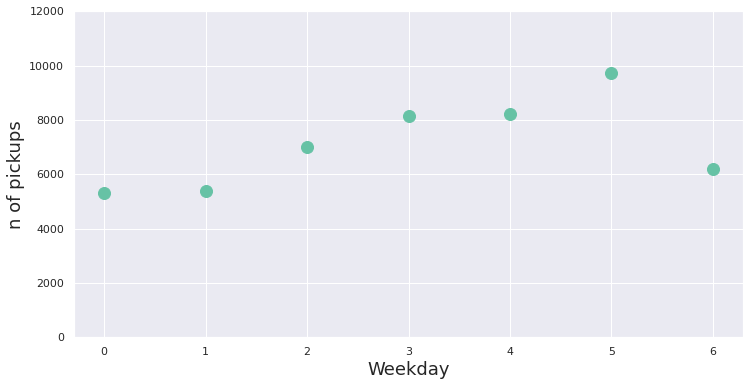

In [502]:
pickups_weekday.groupby('weekday').sum().plot(cmap='Set2',
                                              marker='o',
                                              markersize=12,
                                              linewidth=0,
                                              figsize=(12,6))
plt.ylim(0,12000)
plt.ylabel('n of pickups')
plt.xlabel('Weekday')
plt.show()

* Highest taxi pickups on weekday 5 (='Saturday')
* Lowest taxi pickups on weekday 0 (='Monday')

# Task 2: Train a baseline model for the average number of pickups by block group using as covariates the ACS variables. 


* What is the performance of the model?
* What can we learn from this model?


Since the target n_pickup is a continuous variable, a linear regression algorithm is chosen as a baseline model.

In [ ]:
!!!!!! Only use ACS variables, ONLY grouped

In [543]:
NY_merged[NY_merged['geoid']==360610058001]

,geoid,geometry,index_pickup,pickup_time,aggregate_travel_time_to_work,amerindian_pop,asian_pop,black_pop,commuters_16_over,commuters_by_public_transportation,...,white_pop,n_pickup,borough,area,n_pickup_per_area,month,weekday,week,day,hour
12545,360610058001,"POLYGON ((-8236945.347 4974304.609, -8236586.7...",26451.0,2015-01-18 21:39:06,63665.0,0.0,788.0,0.0,2396.0,1361.0,...,2234.0,464,New York,304594.937391,0.001523,1.0,6.0,3,18.0,21.0
12546,360610058001,"POLYGON ((-8236945.347 4974304.609, -8236586.7...",27532.0,2015-01-17 12:37:19,63665.0,0.0,788.0,0.0,2396.0,1361.0,...,2234.0,464,New York,304594.937391,0.001523,1.0,5.0,3,17.0,12.0
12547,360610058001,"POLYGON ((-8236945.347 4974304.609, -8236586.7...",40556.0,2015-01-20 14:20:40,63665.0,0.0,788.0,0.0,2396.0,1361.0,...,2234.0,464,New York,304594.937391,0.001523,1.0,1.0,4,20.0,14.0
12548,360610058001,"POLYGON ((-8236945.347 4974304.609, -8236586.7...",35108.0,2015-01-08 09:30:16,63665.0,0.0,788.0,0.0,2396.0,1361.0,...,2234.0,464,New York,304594.937391,0.001523,1.0,3.0,2,8.0,9.0
12549,360610058001,"POLYGON ((-8236945.347 4974304.609, -8236586.7...",24273.0,2015-01-28 14:19:24,63665.0,0.0,788.0,0.0,2396.0,1361.0,...,2234.0,464,New York,304594.937391,0.001523,1.0,2.0,5,28.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13004,360610058001,"POLYGON ((-8236945.347 4974304.609, -8236586.7...",40082.0,2015-01-10 15:52:17,63665.0,0.0,788.0,0.0,2396.0,1361.0,...,2234.0,464,New York,304594.937391,0.001523,1.0,5.0,2,10.0,15.0
13005,360610058001,"POLYGON ((-8236945.347 4974304.609, -8236586.7...",3415.0,2015-01-21 08:49:56,63665.0,0.0,788.0,0.0,2396.0,1361.0,...,2234.0,464,New York,304594.937391,0.001523,1.0,2.0,4,21.0,8.0
13006,360610058001,"POLYGON ((-8236945.347 4974304.609, -8236586.7...",45739.0,2015-01-26 07:03:03,63665.0,0.0,788.0,0.0,2396.0,1361.0,...,2234.0,464,New York,304594.937391,0.001523,1.0,0.0,5,26.0,7.0
13007,360610058001,"POLYGON ((-8236945.347 4974304.609, -8236586.7...",27316.0,2015-01-13 12:05:58,63665.0,0.0,788.0,0.0,2396.0,1361.0,...,2234.0,464,New York,304594.937391,0.001523,1.0,1.0,3,13.0,12.0


In [503]:
NY_merged.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 54818 entries, 0 to 54817
Data columns (total 46 columns):
 #   Column                                                       Non-Null Count  Dtype         
---  ------                                                       --------------  -----         
 0   geoid                                                        54818 non-null  int64         
 1   geometry                                                     54818 non-null  geometry      
 2   index_pickup                                                 49984 non-null  float64       
 3   pickup_time                                                  49984 non-null  datetime64[ns]
 4   aggregate_travel_time_to_work                                8489 non-null   float64       
 5   amerindian_pop                                               54818 non-null  float64       
 6   asian_pop                                                    54818 non-null  float64       
 7   black

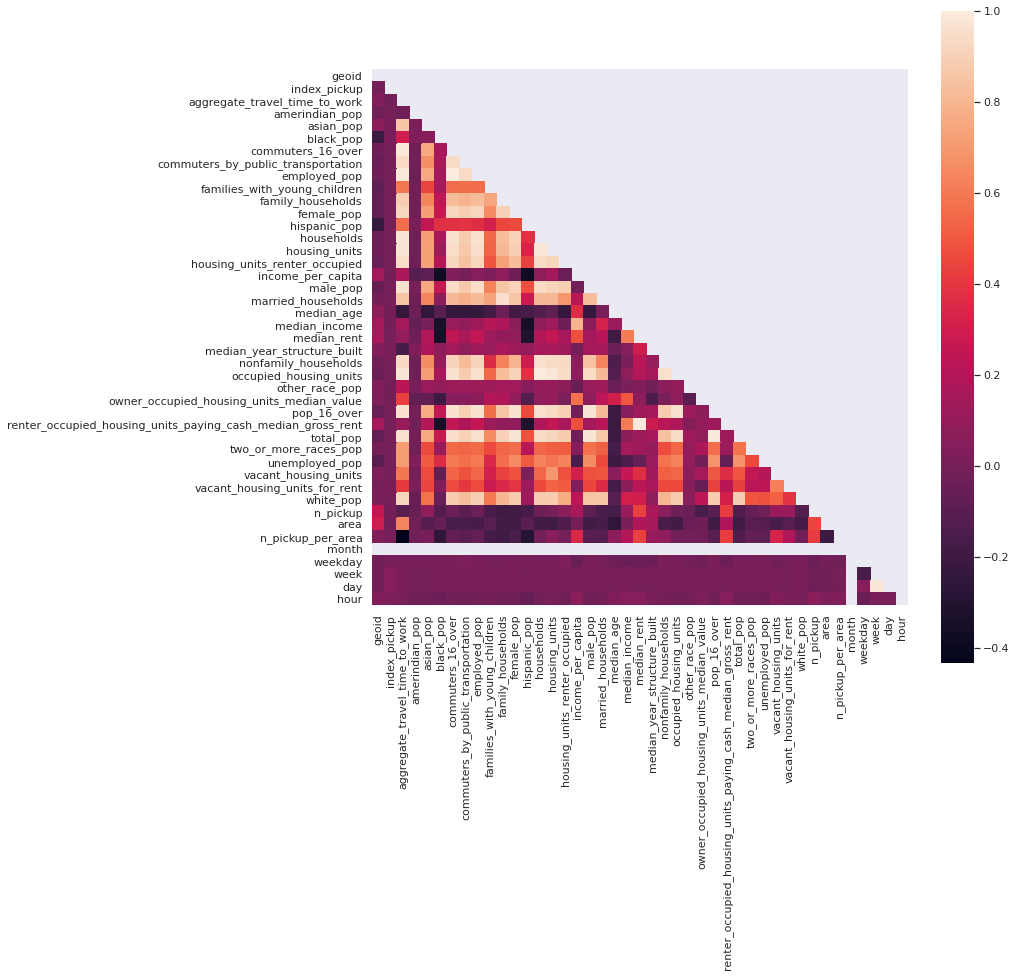

In [509]:
# Check linear correlation

# Redefine the dataframe without geometry or datetime type attributes
cols = [col for col in NY_merged.columns if col not in ['geometry', 'pickup_time']]
NY_df = NY_merged[cols]

# Calculate correlation coeff
corr = NY_df.corr()

# Confusion matrix
plt.figure(figsize=(12,12))
matrix = np.triu(corr)
sns.heatmap(corr, fmt='.1g', square=True, mask=matrix)
plt.show()

In [ ]:
# variable distribution


In [515]:
# Select features highly correlated (r > 0.1) with the target only
select_highly_correlated = abs(corr['n_pickup']) > 0.1
corr[select_highly_correlated]['n_pickup']

geoid                                                          0.254836
aggregate_travel_time_to_work                                 -0.108631
black_pop                                                     -0.124859
families_with_young_children                                  -0.155067
family_households                                             -0.198183
female_pop                                                    -0.178513
hispanic_pop                                                  -0.174684
income_per_capita                                              0.173563
married_households                                            -0.156998
median_age                                                    -0.169560
median_income                                                  0.110753
median_rent                                                    0.429110
median_year_structure_built                                    0.169288
owner_occupied_housing_units_median_value                     -0

In [523]:
selected_features = corr[select_highly_correlated]['n_pickup'].index
NY_df_reduced = NY_df[selected_features]

In [524]:
# Are selected columns numeric?
NY_df_reduced.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

In [525]:
# Any null values?
NY_df_reduced.isnull().sum()

geoid                                                              0
aggregate_travel_time_to_work                                  46329
black_pop                                                          0
families_with_young_children                                       0
family_households                                                  0
female_pop                                                         0
hispanic_pop                                                       0
income_per_capita                                               2754
married_households                                                 0
median_age                                                      2116
median_income                                                   6579
median_rent                                                     5200
median_year_structure_built                                     2855
owner_occupied_housing_units_median_value                      15405
pop_16_over                       

In [526]:
# Impute missing data using most_frequent values since this is just a baseline model
my_imputer = SimpleImputer(strategy='most_frequent')
NY_df_reduced = pd.DataFrame(my_imputer.fit_transform(NY_df_reduced),
                             columns = NY_df_reduced.columns)

In [532]:
NY_df_reduced.isnull().any().sum()

0

In [528]:
target = 'n_pickup'
features = [col for col in NY_df_reduced.columns if col != target]

In [533]:
# train_test split
X_train, X_test, y_train, y_test = train_test_split(NY_df_reduced[features], # X
                                                    NY_df_reduced[target], # y
                                                    test_size=0.3,
                                                    shuffle=True)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(38372, 22)
(16446, 22)
(38372,)
(16446,)


In [534]:
# train model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [535]:
# test
fitted_values = pd.DataFrame({
    'prediction': lr.predict(X_train)
}, index=X_train.index)

mae_in_sample = mean_absolute_error(y_train, fitted_values)
print(f'Mean absolute error in-sample: {mae_in_sample}')

Mean absolute error in-sample: 118.12523017978586


<AxesSubplot:>

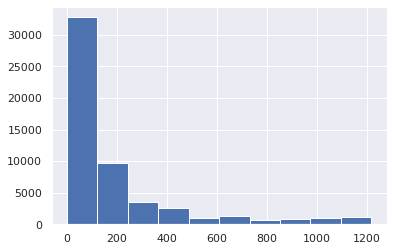

In [537]:
NY_df_reduced.n_pickup.hist()